In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn
import torch
import math
import os
import sys
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import torchvision.transforms as transforms
import torchvision.datasets as dsets

import matplotlib.pyplot as plt

from torch.utils.data import TensorDataset, DataLoader
from matplotlib import pyplot
from datetime import datetime
from torch.autograd import Variable
from torch.nn import Parameter
from torch import Tensor
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox
from time import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch import Tensor
from tqdm.notebook import tqdm
from IPython.display import clear_output

from sklearn.metrics import recall_score, precision_score, accuracy_score

# from imblearn.over_sampling import SMOTE

from torch.nn.modules.activation import ReLU, LeakyReLU, Tanh
import torch.nn.functional as F

from torchinfo import summary


In [8]:
cuda = True if torch.cuda.is_available() else False   
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor    

In [9]:
DATA_DIR = '/data/vapyzh/CASM-floods/'

In [10]:
ls $DATA_DIR

CASM/                                weights_1_1649031580.5322192
CASM_DJF_ex_indicator_grid.txt       weights_1_1649031657.0428581
CASM_coordinate.txt                  weights_1_1649074082.3281558
exday_99per_DJF_CASM_1980_2019.txt   weights_1_1649074114.2898822
nexday_99per_DJF_CASM_1980_2019.txt  weights_1_1649074139.6353889
weights_1_1649027328.278437          weights_1_1649074163.091286
weights_1_1649027360.1894128         weights_1_1649074188.6728516
weights_1_1649027364.0663185         weights_1_1649074214.3590503
weights_1_1649027368.9158125         weights_1_1649074240.8852448
weights_1_1649027371.2999084         weights_1_1649074264.9349103
weights_1_1649027378.6490998         weights_1_1649074288.3058794
weights_1_1649027402.5469725         weights_1_1649074312.2433603
weights_1_1649027405.0325809         weights_1_1649074393.2776654
weights_1_1649027409.4916668         weights_1_1649074420.7723997
weights_1_1649027415.581966          weights_1_1649074445.84565
weights_1_164

In [11]:
coords = pd.read_csv(DATA_DIR + "CASM_coordinate.txt", header=None, sep="   ")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [12]:
coords

,0,1
0,-146.25,61.0
1,-143.75,61.0
2,-141.25,61.0
3,-138.75,61.0
4,-136.25,61.0
...,...,...
451,-111.25,15.0
452,-108.75,15.0
453,-106.25,15.0
454,-103.75,15.0


In [13]:
new_ex_coords = pd.read_csv(DATA_DIR + "CASM_DJF_ex_indicator_grid.txt", header=None, sep="\t")

In [14]:
new_ex_coords

,0,1,2
0,-123.75,41,62
1,-123.75,41,169
2,-123.75,41,297
3,-123.75,41,590
4,-123.75,41,910
...,...,...,...
130,-118.75,41,2348
131,-118.75,41,3320
132,-118.75,41,3325
133,-118.75,41,3349


In [15]:
coords_to_find = new_ex_coords.groupby([0,1]).count().index.to_numpy()

In [16]:
indexes = []
for x,y in coords_to_find:
    indexes.append(coords[(coords[0] == x) & (coords[1] == y)].index.values[0])

In [17]:
indexes

[199, 238, 219, 200, 258, 239, 220, 201]

In [18]:
ex_dates = pd.read_table(DATA_DIR + 'exday_99per_DJF_CASM_1980_2019.txt', delim_whitespace=True, names=('day_of_seq', 'year', 'month', 'day'))
nex_dates = pd.read_table(DATA_DIR + 'nexday_99per_DJF_CASM_1980_2019.txt', delim_whitespace=True, names=('day_of_seq', 'year', 'month', 'day'))

variables = ['h500', 'ivt', 'qv2m', 'slp', 'tpw', 'uqv', 'vqv', 'w500']
concating_values = []
only_today = []

for var in variables:
    ex_df = pd.read_table(DATA_DIR + f'CASM/ERA5_DJF_CASM_99per_ex_n{var}_1980_2019.txt', delim_whitespace=True, header = None)
    nex_df = pd.read_table(DATA_DIR + f'CASM/ERA5_DJF_CASM_99per_nex_n{var}_1980_2019.txt', delim_whitespace=True, header = None)
    ex = pd.concat([ex_dates, ex_df], axis = 1)
    nex = pd.concat([nex_dates, nex_df], axis = 1)
    df = pd.concat([ex, nex], ignore_index=True).sort_values('day_of_seq')
    to_del = list(df[(df['month'] == 2) & (df['day'] == 29)].index)
    df = df.drop(to_del)
    df = df.drop(df[(df['month'] != 12) & (df['year'] == 1980)].index)
    df = df.drop(df[(df['month'] == 12) & (df['year'] == 2019)].index)

    without_first_season = df[df['day_of_seq'] > 150]
    without_last_season = df[df['day_of_seq'] < 3490]

    tmp_df = without_first_season
    tmp_df = tmp_df[(tmp_df['month'] != 12) | (tmp_df['day'] > 7)] # kill first i days
    tmp_df = tmp_df[(tmp_df['month'] != 2) | (tmp_df['day'] < 29)]
    tmp_df = tmp_df.drop(['day_of_seq', 'year', 'month', 'day'], axis=1)
    only_today.append(tmp_df.values.reshape(-1, 24, 19))

    for i in range(7): #shifting prev year data
        tmp_df = without_last_season
        tmp_df = tmp_df[(tmp_df['month'] != 12) | (tmp_df['day'] > i)] # kill first i days
        tmp_df = tmp_df[(tmp_df['month'] != 2) | (tmp_df['day'] < 29 - (7 - i))] # kill last i days
        tmp_df = tmp_df.drop(['day_of_seq', 'year', 'month', 'day'], axis=1)
        concating_values.append(tmp_df.values.reshape(-1, 24, 19))

    for i in range(7): #shifting this year data
        tmp_df = without_first_season
        tmp_df = tmp_df[(tmp_df['month'] != 12) | (tmp_df['day'] > i)] # kill first i days
        tmp_df = tmp_df[(tmp_df['month'] != 2) | (tmp_df['day'] < 29 - (7 - i))] # kill last i day
        tmp_df = tmp_df.drop(['day_of_seq', 'year', 'month', 'day'], axis=1)
        concating_values.append(tmp_df.values.reshape(-1, 24, 19))


In [19]:
np.array(concating_values).shape

concating_values = np.moveaxis(concating_values, 0, 1)

In [20]:
concating_values.shape

(3154, 112, 24, 19)

In [21]:
only_today = np.array(only_today)
only_today = np.moveaxis(only_today, 0, 1)
only_today.shape

(3154, 8, 24, 19)

### Посмотрим на то как дисперсия связана со средним.

In [22]:
means = np.mean(only_today, axis=(2, 3))

In [23]:
means.shape

(3154, 8)

In [24]:
sgn_std = only_today - means.reshape(3154, 8, 1, 1)

In [25]:
sgn_std = np.mean(sgn_std, axis=(2, 3))

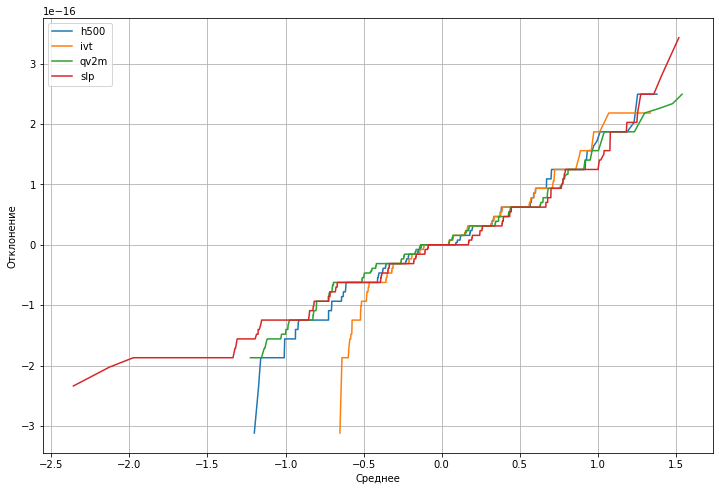

In [26]:
plt.figure(figsize=(12,8))
for i, var in enumerate(variables[:4]):
    tmp = np.array([means[:, i], sgn_std[:, i]])
    tmp = np.sort(tmp)
    plt.plot(tmp[0,:], tmp[1,:], label=var)
plt.xlabel("Среднее")
plt.ylabel("Отклонение")
plt.grid(":")
plt.legend()
plt.show()

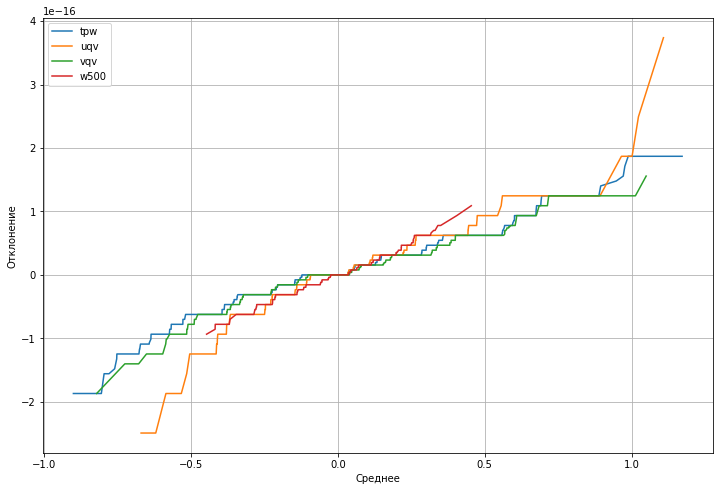

In [27]:
plt.figure(figsize=(12,8))
for i, var in enumerate(variables[4:], start=4):
    tmp = np.array([means[:, i], sgn_std[:, i]])
    tmp = np.sort(tmp)
    plt.plot(tmp[0,:], tmp[1,:], label=var)
plt.xlabel("Среднее")
plt.ylabel("Отклонение")
plt.grid(":")
plt.legend()
plt.show()

### Подготовим теперь таргет. Будем считать 95ый квантиль

In [28]:
ex_dates = pd.read_table(DATA_DIR + 'exday_99per_DJF_CASM_1980_2019.txt', delim_whitespace=True, names=('day_of_seq', 'year', 'month', 'day'))
nex_dates = pd.read_table(DATA_DIR + 'nexday_99per_DJF_CASM_1980_2019.txt', delim_whitespace=True, names=('day_of_seq', 'year', 'month', 'day'))

In [29]:
var = 'tpw'

ex_df = pd.read_table(DATA_DIR + f'CASM/ERA5_DJF_CASM_99per_ex_n{var}_1980_2019.txt', delim_whitespace=True, header = None)
nex_df = pd.read_table(DATA_DIR + f'CASM/ERA5_DJF_CASM_99per_nex_n{var}_1980_2019.txt', delim_whitespace=True, header = None)
ex = pd.concat([ex_dates, ex_df], axis = 1)
nex = pd.concat([nex_dates, nex_df], axis = 1)
df = pd.concat([ex, nex], ignore_index=True).sort_values('day_of_seq')
to_del = list(df[(df['month'] == 2) & (df['day'] == 29)].index)
df = df.drop(to_del)
df = df.drop(df[(df['month'] != 12) & (df['year'] == 1980)].index)
df = df.drop(df[(df['month'] == 12) & (df['year'] == 2019)].index)

without_first_season = df[df['day_of_seq'] > 150]
without_last_season = df[df['day_of_seq'] < 3490]

tmp_df = without_first_season
tmp_df = tmp_df[(tmp_df['month'] != 12) | (tmp_df['day'] > 7)] # kill first i days
tmp_df = tmp_df.drop(['day_of_seq', 'year', 'month', 'day'], axis=1)
# concating_values.append(tmp_df.values.reshape(-1, 24, 19))

quant = np.quantile(tmp_df.values, 0.95)
tmp_df['quant'] = quant
tmp_df['CAL_MEAN'] = np.mean(tmp_df[indexes].values, axis=1)

In [30]:
np.mean(tmp_df[indexes].values, axis=1)

array([0.1875 , 1.13125, 0.46   , ..., 0.99875, 1.19375, 0.4875 ])

In [31]:
tmp_df[indexes + ['quant', 'CAL_MEAN']]

,199,238,219,200,258,239,220,201,quant,CAL_MEAN
228,0.53,0.09,0.32,0.58,-0.03,-0.42,-0.14,0.57,1.82,0.18750
229,1.41,0.98,1.24,1.53,0.78,0.95,1.14,1.02,1.82,1.13125
230,0.01,0.26,0.03,0.39,1.28,0.85,0.39,0.47,1.82,0.46000
231,-0.41,-0.65,-0.19,0.04,-0.09,-0.07,0.10,0.39,1.82,-0.11000
232,0.80,0.26,0.50,0.70,-0.20,0.27,0.50,0.75,1.82,0.44750
...,...,...,...,...,...,...,...,...,...,...
3575,0.90,0.01,0.39,0.57,0.05,0.15,0.41,0.39,1.82,0.35875
3576,1.34,0.26,0.83,1.07,-0.01,0.20,0.47,0.84,1.82,0.62500
3577,0.45,1.25,1.82,1.34,0.15,0.49,1.02,1.47,1.82,0.99875
74,0.77,1.41,1.40,1.12,1.41,1.08,1.06,1.30,1.82,1.19375


In [32]:
tmp_df['target'] = tmp_df['quant'] < tmp_df['CAL_MEAN']

In [33]:
y = tmp_df['target'].to_numpy().reshape(-1).astype(int)

In [34]:
y

array([0, 0, 0, ..., 0, 0, 0])

In [35]:
X_train, X_val, y_train, y_val = train_test_split(concating_values, y, test_size=0.3, shuffle=False)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, shuffle=False)

In [36]:
batch_size = 200
train_features = torch.Tensor(X_train)
train_targets = torch.Tensor(y_train)
val_features = torch.Tensor(X_val)
val_targets = torch.Tensor(y_val)

train = TensorDataset(train_features, train_targets)
val = TensorDataset(val_features, val_targets)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)

In [37]:
device = f"cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [38]:
def plot_learning_curves(history):
    '''
    Функция для вывода лосса и метрики во время обучения.
    :param history: (dict)
    accuracy и loss на обучении и валидации
    '''
    fig = plt.figure(figsize=(20, 7))
    plt.subplot(1,3,1)
    plt.title('Loss', fontsize=15)
    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['val'], label='val')
    plt.ylabel('Loss', fontsize=15)
    plt.xlabel('Epoch', fontsize=15)
    plt.legend()
    
    plt.subplot(1,3,2)
    plt.title('Recall', fontsize=15)
    plt.plot(history['recall']['train'], label='train')
    plt.plot(history['recall']['val'], label='val')
    plt.ylabel('Recall', fontsize=15)
    plt.xlabel('Epoch', fontsize=15)
    plt.legend()
    
    plt.subplot(1,3,3)
    plt.title('Precision', fontsize=15)
    plt.plot(history['precision']['train'], label='train')
    plt.plot(history['precision']['val'], label='val')
    plt.ylabel('Precision', fontsize=15)
    plt.xlabel('Epoch', fontsize=15)
    plt.legend()
    plt.show()

In [39]:
def get_statistics(true, pred):
    TP = (pred * true).sum()
    TN = ((1 - pred) * (1 - true)).sum()
    FP = (pred * (1 - true)).sum()
    FN = ((1 - pred) * true).sum()
    
    return np.array([TP, FP, FN, TN])

def get_precision(stats):
    TP = stats[0]
    FP = stats[1]
    return TP / (TP + FP)

def get_recall(stats):
    TP = stats[0]
    FN = stats[2]
    return TP / (TP + FN)

In [40]:
import gc

In [41]:
def train_with_aug(
    model,
    criterion,
    optimizer,
    scheduler,
    train_batch_gen,
    val_batch_gen,
    model_num,
    num_epochs=50,
):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.
    :param model: обучаемая модель
    :param criterion: функция потерь
    :param optimizer: метод оптимизации
    :param train_batch_gen: генератор батчей для обучения
    :param val_batch_gen: генератор батчей для валидации
    :param num_epochs: количество эпох
    :return: обученная модель
    :return: (dict) accuracy и loss на обучении и валидации ("история" обучения
    '''
    best_loss = None 

    history = defaultdict(lambda: defaultdict(list))
    
    for epoch in tqdm(range(num_epochs)):
        train_loss = 0
        val_loss = 0
        
        train_statistics = np.array([0, 0, 0, 0]) # TP, FP, FN, TN
        start_time = time.time()

        # Устанавливаем поведение dropout / batch_norm в обучение
        model.train(True)

        # На каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in tqdm(train_batch_gen):
            X_batch = X_batch.to(device)
            y_batch = y_batch.type(torch.LongTensor).to(device)
            # Логиты на выходе модели
            logits = model(X_batch)
            # Подсчитываем лосс
            loss = criterion(logits, y_batch.to(device))
            # Обратный проход
            loss.backward()
            # Шаг градиента
            optimizer.step()
            # Зануляем градиенты
            optimizer.zero_grad()
            # Сохраяняем лоссы и точность на трейн
            train_loss += loss.detach().cpu().numpy()
            y_pred = logits.max(1)[1].detach().cpu().numpy()
    
            train_statistics += get_statistics(y_batch.cpu().numpy(), y_pred)

        # Подсчитываем лоссы и сохраням в "историю"
        train_loss /= len(train_batch_gen)
        train_precision = get_precision(train_statistics)
        train_recall = get_recall(train_statistics)
        history['loss']['train'].append(train_loss)
        history['precision']['train'].append(get_precision(train_statistics))
        history['recall']['train'].append(get_recall(train_statistics))
        history['conf_matrix']['train'].append(train_statistics.resize((2, 2)))

        # меняем теперь лернинг рейт
        scheduler.step()
        torch.cuda.empty_cache()
        gc.collect()


        # Устанавливаем поведение dropout / batch_norm в режим тестирования
        
        model.train(False)
        # Полный проход по валидации
        with torch.no_grad(): 
            val_statistics = np.array([0, 0, 0, 0]) # TP, FP, FN, TN


            for X_batch, y_batch in tqdm(val_batch_gen):
                X_batch = X_batch.to(device)
                y_batch = y_batch.type(torch.LongTensor).to(device)
                # Логиты, полученные моделью
                logits = model(X_batch)
                # Лосс на валидации
                loss = criterion(logits, y_batch)
                # Сохраяняем лоссы и точность на валидации
                val_loss += loss.detach().cpu().numpy()
                y_pred = logits.max(1)[1].detach().cpu().numpy()

                val_statistics += get_statistics(y_batch.cpu().numpy(), y_pred)

            # Подсчитываем лоссы и сохраням в "историю"
        val_loss /= len(val_batch_gen)
        val_precision = get_precision(val_statistics)
        val_recall = get_recall(val_statistics)
        history['loss']['val'].append(val_loss)
        history['precision']['val'].append(get_precision(val_statistics))
        history['recall']['val'].append(get_recall(val_statistics))
        history['conf_matrix']['val'].append(val_statistics.resize((2, 2)))
        
        torch.cuda.empty_cache()
        gc.collect()

        if best_loss is None:
            best_loss = val_loss
            torch.save(model.state_dict(), DATA_DIR + 'weights_'\
            + str(model_num) + "_" + str(time.time()))
        elif best_loss > val_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), DATA_DIR + 'weights_'\
            + str(model_num) + "_" + str(time.time()))

            
        clear_output() 
        # Печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
        print(" training loss (in-iteration): \t{:.6f}".format(train_loss))
        print(" validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print(" training recall: \t\t\t{:.2f} %".format(train_recall * 100))
        print(" validation recall: \t\t\t{:.2f} %".format(val_recall * 100))
        print(" training precision: \t\t\t{:.2f} %".format(train_precision * 100))
        print(" validation precision: \t\t\t{:.2f} %".format(val_precision * 100))
        train_statistics.resize((2, 2))
        val_statistics.resize((2, 2))
        print(" training confussion mastrix: \n", train_statistics)
        print(" validation confussion mastrix: \n", val_statistics)
        plot_learning_curves(history)


    return model, history   

In [42]:
model = nn.Sequential()
model.add_module('cv1', nn.Conv2d(112, 480, kernel_size=1))
model.add_module('relu1', nn.ReLU())
model.add_module('bn1', nn.BatchNorm2d(480))

model.add_module('cv2', nn.Conv2d(480, 960, kernel_size=2, padding=1))
model.add_module('relu2', nn.ReLU())
model.add_module('bn2', nn.BatchNorm2d(960))

model.add_module('cv3', nn.Conv2d(960, 1920, kernel_size=2, padding=1))
model.add_module('relu3', nn.ReLU())
model.add_module('bn3', nn.BatchNorm2d(1920))

model.add_module('mp1', nn.MaxPool2d(2))
model.add_module('relu4', nn.ReLU())
model.add_module('bn4', nn.BatchNorm2d(1920))

model.add_module('drop1', nn.Dropout2d(0.2))

model.add_module('cv4', nn.Conv2d(1920, 1920, kernel_size=2, padding=1))
model.add_module('relu5', nn.ReLU())
model.add_module('bn5', nn.BatchNorm2d(1920))

model.add_module('mp2', nn.MaxPool2d(2))
model.add_module('relu6', nn.ReLU())
model.add_module('bn6', nn.BatchNorm2d(1920))

model.add_module('drop2', nn.Dropout2d(0.2))

model.add_module('cv5', nn.Conv2d(1920, 1920, kernel_size=3, stride=2))
model.add_module('relu7', nn.ReLU())
model.add_module('bn7', nn.BatchNorm2d(1920))

model.add_module('flat', nn.Flatten(1))
model.add_module('linear1', nn.Linear(1920 * 6, 1920))
model.add_module('relu8', nn.ReLU())
model.add_module('bn8', nn.BatchNorm1d(1920))

model.add_module('drop3', nn.Dropout(0.2))


model.add_module('linear2', nn.Linear(1920, 640))
model.add_module('relu9', nn.ReLU())
model.add_module('bn9', nn.BatchNorm1d(640))

model.add_module('linear3', nn.Linear(640, 80))
model.add_module('relu10', nn.ReLU())
model.add_module('bn10', nn.BatchNorm1d(80))

model.add_module('drop4', nn.Dropout(0.2))

model.add_module('linear4', nn.Linear(80, 10))
model.add_module('relu11', nn.ReLU())
model.add_module('bn11', nn.BatchNorm1d(10))

model.add_module('linear5', nn.Linear(10, 2))

model = model.to(device)

In [43]:
summary(model, (1, 112, 24, 19))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               --                        --
├─Conv2d: 1-1                            [1, 480, 24, 19]          54,240
├─ReLU: 1-2                              [1, 480, 24, 19]          --
├─BatchNorm2d: 1-3                       [1, 480, 24, 19]          960
├─Conv2d: 1-4                            [1, 960, 25, 20]          1,844,160
├─ReLU: 1-5                              [1, 960, 25, 20]          --
├─BatchNorm2d: 1-6                       [1, 960, 25, 20]          1,920
├─Conv2d: 1-7                            [1, 1920, 26, 21]         7,374,720
├─ReLU: 1-8                              [1, 1920, 26, 21]         --
├─BatchNorm2d: 1-9                       [1, 1920, 26, 21]         3,840
├─MaxPool2d: 1-10                        [1, 1920, 13, 10]         --
├─ReLU: 1-11                             [1, 1920, 13, 10]         --
├─BatchNorm2d: 1-12                      [1, 1920, 13, 10]  

In [44]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-3)
scheduler =  torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lambda epoch: 0.95 ** epoch)
criterion = nn.CrossEntropyLoss()

In [45]:
from collections import defaultdict
import time
from torchinfo import summary

In [46]:
X_train.shape

(2207, 112, 24, 19)

Epoch 20 of 20 took 40.785s
 training loss (in-iteration): 	0.272007
 validation loss (in-iteration): 	0.334879
 training recall: 			93.90 %
 validation recall: 			36.36 %
 training precision: 			81.91 %
 validation precision: 			41.38 %
 training confussion mastrix: 
 [[  77   17]
 [   5 2101]]
 validation confussion mastrix: 
 [[ 12  17]
 [ 21 750]]


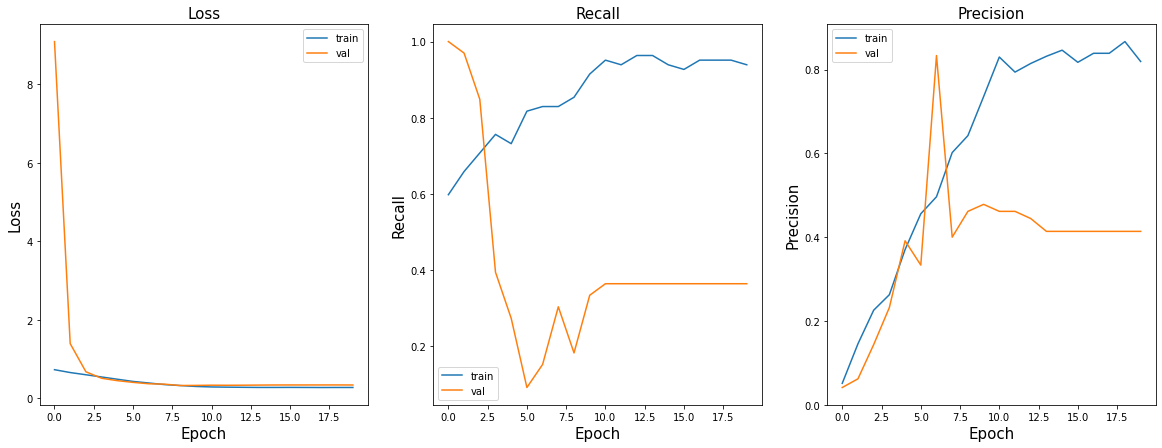

In [34]:
model, history = train_with_aug(model,
                                criterion,
                                optimizer,
                                scheduler,
                                train_loader,
                                val_loader,
                                model_num=1,
                                num_epochs=20)

### Теперь попробуем предсказывать точное значение влажности 

In [47]:
ex_dates = pd.read_table(DATA_DIR + 'exday_99per_DJF_CASM_1980_2019.txt', delim_whitespace=True, names=('day_of_seq', 'year', 'month', 'day'))
nex_dates = pd.read_table(DATA_DIR + 'nexday_99per_DJF_CASM_1980_2019.txt', delim_whitespace=True, names=('day_of_seq', 'year', 'month', 'day'))

In [48]:
var = 'tpw'

ex_df = pd.read_table(DATA_DIR + f'CASM/ERA5_DJF_CASM_99per_ex_n{var}_1980_2019.txt', delim_whitespace=True, header = None)
nex_df = pd.read_table(DATA_DIR + f'CASM/ERA5_DJF_CASM_99per_nex_n{var}_1980_2019.txt', delim_whitespace=True, header = None)
ex = pd.concat([ex_dates, ex_df], axis = 1)
nex = pd.concat([nex_dates, nex_df], axis = 1)
df = pd.concat([ex, nex], ignore_index=True).sort_values('day_of_seq')
to_del = list(df[(df['month'] == 2) & (df['day'] == 29)].index)
df = df.drop(to_del)
df = df.drop(df[(df['month'] != 12) & (df['year'] == 1980)].index)
df = df.drop(df[(df['month'] == 12) & (df['year'] == 2019)].index)

without_first_season = df[df['day_of_seq'] > 150]
without_last_season = df[df['day_of_seq'] < 3490]

tmp_df = without_first_season
tmp_df = tmp_df[(tmp_df['month'] != 12) | (tmp_df['day'] > 7)] # kill first i days
tmp_df = tmp_df.drop(['day_of_seq', 'year', 'month', 'day'], axis=1)
# concating_values.append(tmp_df.values.reshape(-1, 24, 19))

quant = np.quantile(tmp_df.values, 0.95)
tmp_df['quant'] = quant
tmp_df['CAL_MEAN'] = np.mean(tmp_df[indexes].values, axis=1)

In [49]:
np.mean(tmp_df[indexes].values, axis=1)

array([0.1875 , 1.13125, 0.46   , ..., 0.99875, 1.19375, 0.4875 ])

In [50]:
tmp_df[indexes + ['quant', 'CAL_MEAN']]

,199,238,219,200,258,239,220,201,quant,CAL_MEAN
228,0.53,0.09,0.32,0.58,-0.03,-0.42,-0.14,0.57,1.82,0.18750
229,1.41,0.98,1.24,1.53,0.78,0.95,1.14,1.02,1.82,1.13125
230,0.01,0.26,0.03,0.39,1.28,0.85,0.39,0.47,1.82,0.46000
231,-0.41,-0.65,-0.19,0.04,-0.09,-0.07,0.10,0.39,1.82,-0.11000
232,0.80,0.26,0.50,0.70,-0.20,0.27,0.50,0.75,1.82,0.44750
...,...,...,...,...,...,...,...,...,...,...
3575,0.90,0.01,0.39,0.57,0.05,0.15,0.41,0.39,1.82,0.35875
3576,1.34,0.26,0.83,1.07,-0.01,0.20,0.47,0.84,1.82,0.62500
3577,0.45,1.25,1.82,1.34,0.15,0.49,1.02,1.47,1.82,0.99875
74,0.77,1.41,1.40,1.12,1.41,1.08,1.06,1.30,1.82,1.19375


In [51]:
tmp_df['target'] = tmp_df['quant'] < tmp_df['CAL_MEAN']

In [52]:
y = tmp_df['CAL_MEAN'].to_numpy()

In [53]:
y

array([0.1875 , 1.13125, 0.46   , ..., 0.99875, 1.19375, 0.4875 ])

In [54]:
X_train, X_val, y_train, y_val = train_test_split(concating_values, y, test_size=0.3, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, shuffle=False)

In [55]:
batch_size = 16
train_features = torch.Tensor(X_train)
train_targets = torch.Tensor(y_train)
val_features = torch.Tensor(X_val)
val_targets = torch.Tensor(y_val)

train = TensorDataset(train_features, train_targets)
val = TensorDataset(val_features, val_targets)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)

In [56]:
device = f"cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [57]:
def plot_learning_curves(history):
    '''
    Функция для вывода лосса и метрики во время обучения.
    :param history: (dict)
    accuracy и loss на обучении и валидации
    '''
    fig = plt.figure(figsize=(20, 7))
    plt.subplot(1,3,1)
    plt.title('Loss', fontsize=15)
    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['val'], label='val')
    plt.ylabel('Loss', fontsize=15)
    plt.xlabel('Epoch', fontsize=15)
    plt.legend()
    
    plt.subplot(1,3,2)
    plt.title('Recall', fontsize=15)
    plt.plot(history['recall']['train'], label='train')
    plt.plot(history['recall']['val'], label='val')
    plt.ylabel('Recall', fontsize=15)
    plt.xlabel('Epoch', fontsize=15)
    plt.legend()
    
    plt.subplot(1,3,3)
    plt.title('Precision', fontsize=15)
    plt.plot(history['precision']['train'], label='train')
    plt.plot(history['precision']['val'], label='val')
    plt.ylabel('Precision', fontsize=15)
    plt.xlabel('Epoch', fontsize=15)
    plt.legend()
    plt.show()

In [58]:
def get_statistics(true, pred):
    TP = (pred * true).sum()
    TN = ((1 - pred) * (1 - true)).sum()
    FP = (pred * (1 - true)).sum()
    FN = ((1 - pred) * true).sum()
    
    return np.array([TP, FP, FN, TN])

def get_precision(stats):
    TP = stats[0]
    FP = stats[1]
    return TP / (TP + FP)

def get_recall(stats):
    TP = stats[0]
    FN = stats[2]
    return TP / (TP + FN)

In [59]:
import gc

In [60]:
def train_with_aug(
    model,
    criterion,
    optimizer,
    scheduler,
    train_batch_gen,
    val_batch_gen,
    model_num,
    num_epochs=50,
):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.
    :param model: обучаемая модель
    :param criterion: функция потерь
    :param optimizer: метод оптимизации
    :param train_batch_gen: генератор батчей для обучения
    :param val_batch_gen: генератор батчей для валидации
    :param num_epochs: количество эпох
    :return: обученная модель
    :return: (dict) accuracy и loss на обучении и валидации ("история" обучения
    '''
    best_loss = None 

    history = defaultdict(lambda: defaultdict(list))
    
    for epoch in tqdm(range(num_epochs)):
        train_loss = 0
        val_loss = 0
        
        start_time = time.time()

        # Устанавливаем поведение dropout / batch_norm в обучение
        model.train(True)

        # На каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in tqdm(train_batch_gen):
            X_batch = X_batch.to(device)
            y_batch = y_batch.unsqueeze(dim=1).to(device)
            # Логиты на выходе модели
            logits = model(X_batch)
            # Подсчитываем лосс
            loss = criterion(logits, y_batch)
            # Обратный проход
            loss.backward()
            # Шаг градиента
            optimizer.step()
            # Зануляем градиенты
            optimizer.zero_grad()
            # Сохраяняем лоссы и точность на трейн
            train_loss += loss.detach().cpu().numpy()
    

        # Подсчитываем лоссы и сохраням в "историю"
        train_loss /= len(train_batch_gen)
        history['loss']['train'].append(train_loss)

        # меняем теперь лернинг рейт
        scheduler.step()
        torch.cuda.empty_cache()
        gc.collect()


        # Устанавливаем поведение dropout / batch_norm в режим тестирования
        
        model.train(False)
        # Полный проход по валидации
        with torch.no_grad(): 


            for X_batch, y_batch in tqdm(val_batch_gen):
                X_batch = X_batch.to(device)
                y_batch = y_batch.unsqueeze(dim=1).to(device)
                # Логиты, полученные моделью
                logits = model(X_batch)
                
                # Лосс на валидации
                loss = criterion(logits, y_batch)
                # Сохраяняем лоссы и точность на валидации
                val_loss += loss.detach().cpu().numpy()

            # Подсчитываем лоссы и сохраням в "историю"
        val_loss /= len(val_batch_gen)
        history['loss']['val'].append(val_loss)
       
        torch.cuda.empty_cache()
        gc.collect()

        if best_loss is None:
            best_loss = val_loss
            torch.save(model.state_dict(), DATA_DIR + 'weights_'\
            + str(model_num) + "_" + str(time.time()))
        elif best_loss > val_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), DATA_DIR + 'weights_'\
            + str(model_num) + "_" + str(time.time()))

            
        clear_output() 
        # Печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
        print(" training loss (in-iteration): \t{:.6f}".format(train_loss))
        print(" validation loss (in-iteration): \t{:.6f}".format(val_loss))
        
        plot_learning_curves(history)


    return model, history   

In [61]:
model = nn.Sequential()
model.add_module('cv1', nn.Conv2d(112, 480, kernel_size=1))
model.add_module('relu1', nn.ReLU())
model.add_module('bn1', nn.BatchNorm2d(480))

model.add_module('cv2', nn.Conv2d(480, 960, kernel_size=2, padding=1))
model.add_module('relu2', nn.ReLU())
model.add_module('bn2', nn.BatchNorm2d(960))

model.add_module('cv3', nn.Conv2d(960, 1920, kernel_size=2, padding=1))
model.add_module('relu3', nn.ReLU())
model.add_module('bn3', nn.BatchNorm2d(1920))

model.add_module('mp1', nn.MaxPool2d(2))
model.add_module('relu4', nn.ReLU())
model.add_module('bn4', nn.BatchNorm2d(1920))

model.add_module('drop1', nn.Dropout2d(0.2))

model.add_module('cv4', nn.Conv2d(1920, 1920, kernel_size=2, padding=1))
model.add_module('relu5', nn.ReLU())
model.add_module('bn5', nn.BatchNorm2d(1920))

model.add_module('mp2', nn.MaxPool2d(2))
model.add_module('relu6', nn.ReLU())
model.add_module('bn6', nn.BatchNorm2d(1920))

model.add_module('drop2', nn.Dropout2d(0.2))

model.add_module('cv5', nn.Conv2d(1920, 1920, kernel_size=3, stride=2))
model.add_module('relu7', nn.ReLU())
model.add_module('bn7', nn.BatchNorm2d(1920))

model.add_module('flat', nn.Flatten(1))
model.add_module('linear1', nn.Linear(1920 * 6, 1920))
model.add_module('relu8', nn.ReLU())
model.add_module('bn8', nn.BatchNorm1d(1920))

model.add_module('drop3', nn.Dropout(0.2))


model.add_module('linear2', nn.Linear(1920, 640))
model.add_module('relu9', nn.ReLU())
model.add_module('bn9', nn.BatchNorm1d(640))

model.add_module('linear3', nn.Linear(640, 80))
model.add_module('relu10', nn.ReLU())
model.add_module('bn10', nn.BatchNorm1d(80))

model.add_module('drop4', nn.Dropout(0.2))

model.add_module('linear4', nn.Linear(80, 10))
model.add_module('relu11', nn.ReLU())
model.add_module('bn11', nn.BatchNorm1d(10))

model.add_module('linear5', nn.Linear(10, 1))

model = model.to(device)

In [62]:
summary(model, (1, 112, 24, 19))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               --                        --
├─Conv2d: 1-1                            [1, 480, 24, 19]          54,240
├─ReLU: 1-2                              [1, 480, 24, 19]          --
├─BatchNorm2d: 1-3                       [1, 480, 24, 19]          960
├─Conv2d: 1-4                            [1, 960, 25, 20]          1,844,160
├─ReLU: 1-5                              [1, 960, 25, 20]          --
├─BatchNorm2d: 1-6                       [1, 960, 25, 20]          1,920
├─Conv2d: 1-7                            [1, 1920, 26, 21]         7,374,720
├─ReLU: 1-8                              [1, 1920, 26, 21]         --
├─BatchNorm2d: 1-9                       [1, 1920, 26, 21]         3,840
├─MaxPool2d: 1-10                        [1, 1920, 13, 10]         --
├─ReLU: 1-11                             [1, 1920, 13, 10]         --
├─BatchNorm2d: 1-12                      [1, 1920, 13, 10]  

In [63]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-3)
scheduler =  torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lambda epoch: 0.95 ** epoch)
criterion = nn.L1Loss()

In [64]:
from collections import defaultdict
import time
from torchinfo import summary

In [65]:
X_train.shape

(2207, 112, 24, 19)

Epoch 20 of 20 took 17.394s
 training loss (in-iteration): 	0.399180
 validation loss (in-iteration): 	0.418929


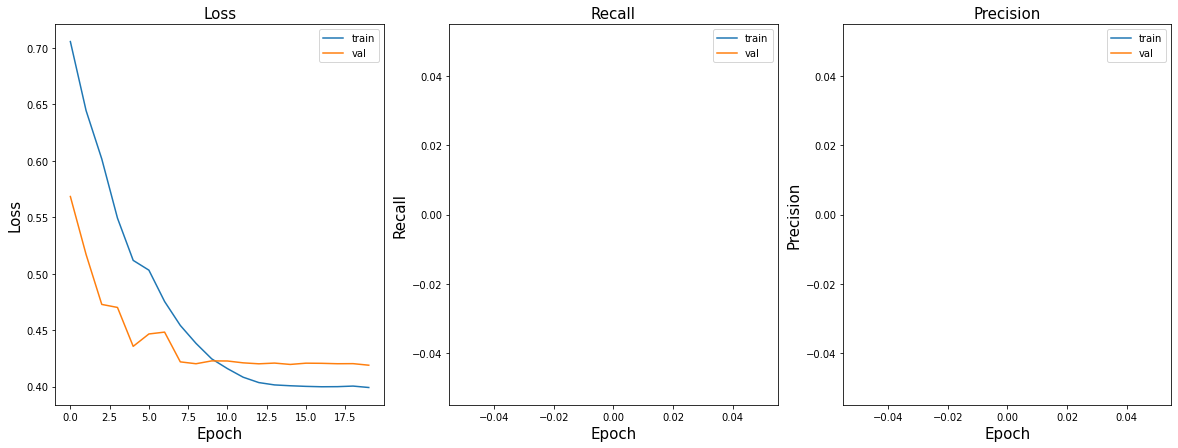

In [66]:
model, history = train_with_aug(model,
                                criterion,
                                optimizer,
                                scheduler,
                                train_loader,
                                val_loader,
                                model_num=2,
                                num_epochs=20)

In [67]:
batch_size = 16
test_features = torch.Tensor(X_test)
test_targets = torch.Tensor(y_test)

test = TensorDataset(test_features, test_targets)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)

In [68]:
prediction = []
true = []

with torch.no_grad():
        for X_batch, y_batch in tqdm(test_loader):
                X_batch = X_batch.to(device)
                # Логиты, полученные моделью
                logits = model(X_batch)
                
                # Лосс на валидации
                prediction += list(logits.detach().cpu().numpy()[:, 0])
                true += list(y_batch.detach().cpu().numpy())
                

In [69]:
true = np.array(true)
prediction = np.array(prediction)

In [70]:
pip install sklearn

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [71]:
def mape(true, pred):
    return 1/len(true) * np.sum(np.abs(1 - pred / true))

In [72]:
mape(true, prediction)

2.7716603772393587

In [81]:
prediction_based_on_quants = prediction > np.quantile(prediction, 0.95)

In [86]:
true_based_on_quants= true > 1.82

In [89]:
recall_score(true_based_on_quants, prediction_based_on_quants)

0.3793103448275862

In [90]:
precision_score(true_based_on_quants, prediction_based_on_quants)

0.4583333333333333